# Explicación Paso a Paso: Generación de Rutas

Este notebook detalla el funcionamiento interno del algoritmo `generar_rutas` utilizado en `PathPlannerTabManager`. Se desglosan las etapas de carga de datos, procesamiento geométrico, generación de grafos y cálculo de trayectorias. Es un algoritmo de Planificación Probabilística de Hoja de Ruta (Probabilistic RoadMap - PRM) simplificado y determinista, adaptado a estructuras viales. En lugar de tirar puntos al azar, usa la estructura de "Calles" definida por el usuario como columna vertebral y proyecta extensiones hacia los objetivos (pozos), validando footprint y colisiones en cada paso.

In [1]:
import sys
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString
from shapely.ops import linemerge, nearest_points
import shapely.affinity
import numpy as np
import math
import networkx as nx
import torch
from sklearn.decomposition import PCA
import random

# ==========================================
# Utilities and Helper Functions (Embedded)
# ==========================================

class GuiTextException(Exception):
    pass

connect_holes = False
del_colliding_poses = True

# --- From fit_streets.py ---

def translate(xarr, yarr, tx, ty):
    xret = []
    yret = []
    for i in range(len(xarr)):
        x = xarr[i] + tx
        y = yarr[i] + ty
        xret.append(x)
        yret.append(y)
    return xret, yret

def rotate(xarr, yarr, angle):
    xret = []
    yret = []
    for i in range(len(xarr)):
        x = math.cos(angle) * xarr[i] - math.sin(angle) * yarr[i]
        y = math.sin(angle) * xarr[i] + math.cos(angle) * yarr[i]
        xret.append(x)
        yret.append(y)
    return xret, yret

def get_pca_transform(xarr,yarr):
    n = len(xarr)
    X = []
    sx = 0
    sy = 0
    for i in range(n):
        X.append((xarr[i],yarr[i]))
        sx += xarr[i]
        sy += yarr[i]
    pca = PCA(n_components=2)
    X_fit = pca.fit(X)
    angle = math.atan2(pca.components_[0,1], pca.components_[0,0])
    return sx/n, sy/n, angle

def select_near_holes(xarr, yarr, holesx, holesy, d_thr):
    curve_xy = [(xarr[i],yarr[i]) for i in range(len(xarr))]
    holes_xy = [(holesx[i],holesy[i]) for i in range(len(holesx))]

    curve = shapely.LineString(curve_xy)
    holes = shapely.MultiPoint(holes_xy)

    street = shapely.buffer(curve, d_thr)
    holes = street.intersection(holes)

    xret = []
    yret = []

    if not holes.is_empty:
        if type(holes) == shapely.MultiPoint:
            for xy in holes.geoms:
                xret.append(xy.x)
                yret.append(xy.y)
        else:
            xret.append(holes.x)
            yret.append(holes.y)

    return xret, yret

def select_near_geofence_points(xarr, yarr, geofx, geofy, d_thr):
    return select_near_holes(xarr, yarr, geofx, geofy, d_thr)

def sample_polygon(polygon, dist = 1.0):
    boundary = polygon.boundary
    length = boundary.length
    points = shapely.line_interpolate_point(boundary, [x for x in np.arange(0, length, dist)])
    xret = []
    yret = []
    for xy in points:
        xret.append(xy.x)
        yret.append(xy.y)
    return xret, yret

def my_loss(x, y, yo, xh, yh, xlow, ylow, xhigh, yhigh):
    loss = 0
    loss += 0.05 * torch.mean((y[1:-1]-yo[1:-1])**2)
    curvature2 = (y[0:-2] + y[2:] - 2*y[1:-1] )**2 / (x[2:] - x[:-2])**2
    loss += 60*torch.mean(curvature2)
    loss += 200*torch.mean((curvature2-0.003)*torch.nn.ReLU()(curvature2-0.003))
    loss += 10 * (y[0]-yo[0])**2
    loss += 10 * (y[1]-yo[1])**2
    loss += 10 * (y[-2]-yo[-2])**2
    loss += 10 * (y[-1]-yo[-1])**2

    xh = torch.reshape(xh, (xh.shape[0], 1))
    yh = torch.reshape(yh, (yh.shape[0], 1))
    dx = x - xh
    dy = y - yh
    d2 = dx**2 + dy**2
    loss += (0.5 / d2 * torch.sigmoid(3*3 - d2)).sum()
    loss += (20.0 / (d2+0.5) * torch.sigmoid(5*(2.1*2.1 - d2)) ).sum()

    L = torch.sqrt( (x[2:] - x[:-2])**2 + (y[2:] - y[:-2])**2)
    C = (x[2:] - x[:-2]) / L
    S = (y[2:] - y[:-2]) / L
    xp = x[1:-1] + 3 * C
    yp = y[1:-1] + 3 * S

    xlow = torch.reshape(xlow, (xlow.shape[0], 1))
    ylow = torch.reshape(ylow, (ylow.shape[0], 1))
    dx = x - xlow
    dy = y - ylow
    d2 = dx**2 + dy**2
    loss += (20.0 / (d2+0.5) * torch.sigmoid(5*(2.1*2.1 - d2)) ).sum()

    xhigh = torch.reshape(xhigh, (xhigh.shape[0], 1))
    yhigh = torch.reshape(yhigh, (yhigh.shape[0], 1))
    dx = x - xhigh
    dy = y - yhigh
    d2 = dx**2 + dy**2
    loss += (20.0 / (d2+0.5) * torch.sigmoid(5*(2.1*2.1 - d2)) ).sum()

    dx = xp - xhigh[1:-1,:]
    dy = yp - yhigh[1:-1,:]
    d2 = dx**2 + dy**2
    loss += (2.0 / (d2+0.5) * torch.sigmoid(5*(2.1*2.1 - d2)) ).sum()

    return loss

class CurveModel(torch.nn.Module):
  def __init__(self, device, x, y0):
    super(CurveModel, self).__init__()
    self.yb = torch.clone(y0).to(device=device)
    self.y = torch.nn.Parameter(self.yb)
  def forward(self, x):
    return self.y

def gen_footprint_obstacle(x,y,angle):
    back = -3.5
    front = 3.5
    left = 1.8 
    right = -1.8
    c = math.cos(angle)
    s = math.sin(angle)
    footprint = shapely.Polygon([
        [x+c*back -s*left,  y+s*back +c*left],
        [x+c*front-s*left,  y+s*front+c*left],
        [x+c*front-s*right, y+s*front+c*right],
        [x+c*back -s*right, y+s*back +c*right],
        [x+c*back -s*left,  y+s*back +c*left]
    ])    
    return footprint

def gen_footprint_high_obstacle(x,y,angle):
    back = -3.5
    front = 6.5
    left = 1.8 
    right = -1.8
    c = math.cos(angle)
    s = math.sin(angle)
    footprint = shapely.Polygon([
        [x+c*back -s*left,  y+s*back +c*left],
        [x+c*front-s*left,  y+s*front+c*left],
        [x+c*front-s*right, y+s*front+c*right],
        [x+c*back -s*right, y+s*back +c*right],
        [x+c*back -s*left,  y+s*back +c*left]
    ])    
    return footprint

def fit_street(orig_x, orig_y, holes_x, holes_y, low_x, low_y, high_x, high_y):
    tx, ty, angle = get_pca_transform(orig_x,orig_y)
    orig_x, orig_y = translate(orig_x, orig_y, -tx, -ty)
    orig_x, orig_y = rotate(orig_x, orig_y, -angle)
    holes_x, holes_y = translate(holes_x, holes_y, -tx, -ty)
    holes_x, holes_y = rotate(holes_x, holes_y, -angle)    
    low_x, low_y = translate(low_x, low_y, -tx, -ty)
    low_x, low_y = rotate(low_x, low_y, -angle)    
    high_x, high_y = translate(high_x, high_y, -tx, -ty)
    high_x, high_y = rotate(high_x, high_y, -angle)    

    device = torch.device('cpu:0')
    xo = torch.Tensor(orig_x).to(device)
    yo = torch.Tensor(orig_y).to(device)
    xh = torch.Tensor(holes_x).to(device)
    yh = torch.Tensor(holes_y).to(device)
    xlow = torch.Tensor(low_x).to(device)
    ylow = torch.Tensor(low_y).to(device)
    xhigh = torch.Tensor(high_x).to(device)
    yhigh = torch.Tensor(high_y).to(device)

    model = CurveModel(device, xo, yo)
    optim = torch.optim.Adam(model.parameters(), lr=0.001)
    n_iters = 300
    for i in range(0, n_iters):
        if i == 100: 
            for g in optim.param_groups: g['lr'] = 0.01
        if i == 200: 
            for g in optim.param_groups: g['lr'] = 0.03
        predictions = model.forward(xo)
        loss = my_loss(xo, predictions, yo, xh, yh, xlow, ylow, xhigh, yhigh)
        loss.backward()
        optim.step()
        optim.zero_grad()

    curve_x = orig_x
    curve_y = predictions.detach().cpu().numpy()
    curve_x, curve_y = rotate(curve_x, curve_y, angle)
    curve_x, curve_y = translate(curve_x, curve_y, tx, ty)
    return curve_x, curve_y

def del_colliding(orig_x, orig_y, holes_x, holes_y, low_x, low_y, high_x, high_y):
    tx, ty, angle = get_pca_transform(orig_x,orig_y)
    orig_x, orig_y = translate(orig_x, orig_y, -tx, -ty)
    orig_x, orig_y = rotate(orig_x, orig_y, -angle)
    holes_x, holes_y = translate(holes_x, holes_y, -tx, -ty)
    holes_x, holes_y = rotate(holes_x, holes_y, -angle)    
    low_x, low_y = translate(low_x, low_y, -tx, -ty)
    low_x, low_y = rotate(low_x, low_y, -angle)    
    high_x, high_y = translate(high_x, high_y, -tx, -ty)
    high_x, high_y = rotate(high_x, high_y, -angle)    
    
    holes = shapely.MultiPoint([[holes_x[i],holes_x[i]] for i in range(len(holes_x))])
    low = shapely.MultiPoint([[low_x[i],low_y[i]] for i in range(len(low_x))])
    high = shapely.MultiPoint([[high_x[i],high_y[i]] for i in range(len(high_x))])

    curve_x = []
    curve_y = []
    for i in range(len(orig_x)):
        if i > 0: ori = math.atan2(orig_y[i]-orig_y[i-1], orig_x[i]-orig_x[i-1])
        else: ori = math.atan2(orig_y[i+1]-orig_y[i], orig_x[i+1]-orig_x[i])
        footprint = gen_footprint_obstacle(orig_x[i], orig_y[i], ori)
        footprint_high = gen_footprint_high_obstacle(orig_x[i], orig_y[i], ori)
        if not holes.intersects(footprint) and not low.intersects(footprint) and not high.intersects(footprint_high):
            curve_x.append(orig_x[i])
            curve_y.append(orig_y[i])
    curve_x, curve_y = rotate(curve_x, curve_y, angle)
    curve_x, curve_y = translate(curve_x, curve_y, tx, ty)
    return curve_x, curve_y

def fit_all_streets(streets, holes, geofence, obstacles, high_obstacles, fit_twice, progress_callback=None):
    all_holes_x = holes['x'].to_list()
    all_holes_y = holes['y'].to_list()
    all_geof_x, all_geof_y = sample_polygon(geofence.geometry.iloc[0])
    low_x = []
    low_y = []
    if obstacles is not None:
        for row in obstacles.geometry:
            cx, cy = sample_polygon(row)
            low_x += cx
            low_y += cy
    if high_obstacles is not None:
        for row in high_obstacles.geometry:
            cx, cy = sample_polygon(row)
            all_geof_x += cx
            all_geof_y += cy
    total_streets = len(streets)
    for index, row in streets.iterrows():
        if progress_callback:
            progress_callback(1 + 9 * (index / total_streets))
        street = shapely.segmentize(row['geometry'], max_segment_length=1.0)
        orig_x = []
        orig_y = []
        for xy in list(street.coords):
            orig_x.append(xy[0])
            orig_y.append(xy[1])
        holes_x, holes_y = select_near_holes(orig_x, orig_y, all_holes_x, all_holes_y, 7.0)
        geof_x, geof_y = select_near_geofence_points(orig_x, orig_y, all_geof_x, all_geof_y, 11.0)
        curve_x, curve_y = fit_street(orig_x, orig_y, holes_x, holes_y, low_x, low_y, geof_x, geof_y)
        if fit_twice:
            curve_x, curve_y = del_colliding(curve_x, curve_y, holes_x, holes_y, low_x, low_y, geof_x, geof_y)
            curve_x, curve_y = fit_street(curve_x, curve_y, holes_x, holes_y, low_x, low_y, geof_x, geof_y)
        xy = []
        for i in range(len(curve_x)):
            xy.append( (curve_x[i], curve_y[i]) )
        streets.loc[index, 'geometry'] = shapely.LineString(xy)
        streets.loc[index, 'geometry'] = shapely.simplify(streets.loc[index, 'geometry'], 0.1)
    return streets

# --- From utils.py ---

def readHolFile(filename, WGS84):
    if filename.endswith(".hol"):
        with open(filename, 'r') as f:
            lines = f.readlines()
            lines = [ line.strip() for line in lines]
            lines = [list(filter(None,line.split(' ') )) for line in lines]
            lines = [[float(line[0]), float(line[1]) ,float(line[2]) ,float(line[3]) ,float(line[4]) ,float(line[5]) , float(line[6]) , float(line[7]) , int(line[8]) , line[9]   ] for line in lines]
        gdf = gpd.GeoDataFrame(lines, columns=['x', 'y', 'z', 'z_hole', 'unkown0', 'unkown1', 'unkown2', 'unkown3', 'drillhole_id', 'mesh'])
    elif filename.endswith(".csv"):
        df = pd.read_csv(filename)
        df['x'] = df['Drill collar X (m)']
        df['y'] = df['Drill collar Y (m)']
        df['z'] = df['Drill collar Z (m)']
        df['z_hole'] = df['Drill collar Z (m)'] - df['Drill depth (m)']
        df['drillhole_id'] = df['Hole ID']
        gdf = gpd.GeoDataFrame({'x':df['x'], 'y':df['y'], 'z':df['z'], 'z_hole': df['z_hole'], 'drillhole_id': df['drillhole_id']})
    else:
        print("Unsupported format")
        return None

    gdf = gdf.set_geometry(list(gpd.points_from_xy(gdf.x, gdf.y)))
    gdf['type'] = 'hole'
    if(WGS84):
        gdf.crs = 'EPSG:32719'
    else:
        gdf.crs = 'EPSG:4326'
        gdf = gdf.to_crs('EPSG:32719')
    return gdf

def plotPose(pose):
    start = (pose[0], pose[1])
    end = (pose[0] + .5*math.cos(pose[2]), pose[1] + 0.5*math.sin(pose[2]))
    arrow = mpatch.FancyArrowPatch( start , end  , transform=plt.gca().transData, arrowstyle='->', mutation_scale=10.0)
    plt.gca().add_patch(arrow)

def split_ring(ring, split):
    valid_types = ('MultiLineString', 'LineString', 'GeometryCollection')
    if ring.geom_type == 'LinearRing':
        ring = LineString(ring)
    if split.is_empty:
        return ring
    if not split.intersects(ring):
        return ring
    intersections = ring.intersection(split)
    if intersections.is_empty:
        return ring
    elif intersections.geom_type == 'Point':
        result = Polygon(ring).difference(split).exterior
        coords = result.coords[:-1]
        found_i = 0
        for i, c in enumerate(coords):
            if Point(c).almost_equals(intersections):
                found_i = i
                break
        if found_i > 0:
            result = Polygon(coords[i:] + coords[:i]).exterior
        return LineString(result)
    difference = ring.difference(split)
    start_point = ring.interpolate(0)
    if start_point.distance(intersections) == 0:
        return difference
    fuse = []
    parts = list(difference.geoms)
    for ipart, part in enumerate(parts):
        if part.intersects(start_point):
            fuse.append(ipart)
    if len(fuse) == 2:
         popped_part = parts.pop(fuse[1])
         parts[fuse[0]] = linemerge([parts[fuse[0]], popped_part])
    return parts

def generatePoseCandidate(pose, hole,  blocked, turning_radius, hole_distance, dont_go_back = True):
    start = shapely.geometry.Point(pose[0],pose[1])
    turning_points =  shapely.geometry.Point(pose[0] + turning_radius*math.cos(pose[2]+math.pi/2.0), pose[1] + turning_radius*math.sin(pose[2]+math.pi/2.0)).union(
        shapely.geometry.Point(pose[0] + turning_radius*math.cos(pose[2]-math.pi/2.0), pose[1] + turning_radius*math.sin(pose[2]-math.pi/2.0)))
    turning_point,_ = nearest_points(turning_points,hole)
    if turning_point.distance(hole) < turning_radius:
        return None ,None ,None
    envelope = turning_point.buffer(turning_radius).union(hole).convex_hull.boundary
    buffered_hole = hole.buffer(hole_distance).boundary
    splitter = turning_points.convex_hull.union(buffered_hole)
    split_trajectory = split_ring(envelope, splitter)
    
    if isinstance(split_trajectory, LineString):
         split_trajectory = [split_trajectory]
    elif hasattr(split_trajectory, 'geoms'): 
         split_trajectory = list(split_trajectory.geoms)
    elif not isinstance(split_trajectory, list):
         split_trajectory = [split_trajectory]

    trajectory = None
    for traj  in split_trajectory :
        if traj is None: continue
        start_point = traj.interpolate(0)
        end_point = traj.interpolate(traj.length)
        if start_point.distance(start) < 0.01:
            diff = traj.interpolate(0.1)
            start_angle = math.atan2(diff.y - start_point.y, diff.x - start_point.x)
            angle_error = start_angle-pose[2]
            while angle_error > math.pi: angle_error -= 2*math.pi
            while angle_error < -math.pi: angle_error += 2*math.pi
            if abs(angle_error) < math.pi/4:
                trajectory = traj
                break
        if end_point.distance(start) < 0.01:
            diff = traj.interpolate(traj.length-0.1)
            start_angle = math.atan2(diff.y - end_point.y, diff.x - end_point.x)
            angle_error = start_angle-pose[2]
            while angle_error > math.pi: angle_error -= 2*math.pi
            while angle_error < -math.pi: angle_error += 2*math.pi
            if abs(angle_error) < math.pi/4:
                trajectory = traj.reverse()
                break
    if trajectory is None: return None, None, None

    end_point = trajectory.interpolate(trajectory.length)
    if turning_point.buffer(turning_radius+0.001).intersects(end_point):
        return None ,None ,None
    
    if dont_go_back:
        end_diff = trajectory.interpolate(trajectory.length-0.1)
        end_angle = math.atan2(end_point.y - end_diff.y, end_point.x - end_diff.x)
        end_angle_error = end_angle - pose[2]
        while end_angle_error > math.pi: end_angle_error -= 2*math.pi
        while end_angle_error < -math.pi: end_angle_error += 2*math.pi
        if abs(end_angle_error) > math.pi/2:
            return None, None, None

    pose_candidate = [end_point.x, end_point.y, math.atan2( hole.y - end_point.y, hole.x - end_point.x)]
    if trajectory.intersects(blocked):
        return None ,None ,None
    pose_candidates = []
    l=3.0
    while l < trajectory.length:
        point = trajectory.interpolate(l)
        diff = trajectory.interpolate(l+0.1)
        angle = math.atan2(diff.y - point.y, diff.x - point.x)
        pose_candidates.append([point.x, point.y, angle])
        l += 3.0
    pose_candidates.append(pose_candidate)
    return pose_candidates, trajectory.distance(blocked) , trajectory.length

def generateLoadingPoses(streets, holes, blocked, prev_poses, obstacle_buffer_distance, turning_radius, hole_distance, progress_callback):
    print ('generating loading poses')
    plt.close('all')
    poses_field = []
    all_poses = []
    drillhole_order = []
    extra_connections = []
    hole_num = 0

    for index, row in holes.iterrows():
        poses = []
        order = 10000000000
        if row['type'] == 'hole' :
            closest_street_idx = row['closest_street']
            max_ditance = 0
            min_length = 100000000
            blocked_without_pose = blocked.difference(row['geometry'].buffer(obstacle_buffer_distance+0.01) )
            min_length_pose = None
            min_idx = None
            min_length_idx = None
            for pose_num ,  pose_street in enumerate(streets['poses'][closest_street_idx]):
                pose_candidates , distance , length = generatePoseCandidate(pose_street, row['geometry'], blocked_without_pose, turning_radius, hole_distance)
                if pose_candidates != None :
                    if distance > max_ditance:
                        max_ditance = distance
                        poses = pose_candidates
                        min_idx = pose_num
                    if distance > 2.0:
                        if length < min_length:
                            min_length = length
                            min_length_pose = pose_candidates
                            min_length_idx = pose_num
            if min_length_pose != None:
                poses = min_length_pose
                min_idx = min_length_idx
            if min_idx != None:
                order = 1+len(sum(streets['poses'][0:closest_street_idx],[])) + min_idx
                extra_connections.append([order, len(prev_poses) +len(all_poses)])
                for i in range(1,len(poses)):
                    extra_connections.append([len(prev_poses) +len(all_poses) + i-1 , len(prev_poses) +len(all_poses) + i ])
            hole_num += 1
            if len(poses) == 0:
                print ('no poses found')
                print('pozo no encontrado: ', row['drillhole_id'])
            if progress_callback:
                 progress_callback.emit(10+20*hole_num/len(holes))
        drillhole_order.append(order)
        poses_field.append(poses)
        for pose in poses:
            all_poses.append(pose)

    holes['drillhole_order'] = np.argsort(np.argsort(drillhole_order))
    holes['poses'] = poses_field
    return poses_field, extra_connections

def posesFromGeoDataFrame(gdf, blocked = None, low_obs = None, high_obs = None, geofence = None, step_distance=0.5):
    all_poses = []
    poses_field = []

    if low_obs is not None and low_obs.geometry.shape[0] > 0:
        all_low_obs = shapely.unary_union(low_obs.geometry)
    if high_obs is not None and high_obs.geometry.shape[0] > 0:
        all_high_obs = shapely.unary_union(high_obs.geometry)
    all_geofence = geofence.geometry.iloc[0]

    for index, row in gdf.iterrows():
        poses = []
        if row['type'] == 'streets' or row['type'] == 'transit_streets':
            for i in range(len(row['geometry'].coords[:])-1):
                angle = math.atan2(row['geometry'].coords[i+1][1] - row['geometry'].coords[i][1], row['geometry'].coords[i+1][0] - row['geometry'].coords[i][0])
                point = [row['geometry'].coords[i][0], row['geometry'].coords[i][1], angle]
                dist = math.sqrt((point[1] - row['geometry'].coords[i+1][1])**2 + (point[0] - row['geometry'].coords[i+1][0])**2)
                while dist > .510:
                    foot = gen_footprint_obstacle(point[0], point[1], angle)
                    foot_high = gen_footprint_high_obstacle(point[0], point[1], angle)
                    ok = True
                    if del_colliding_poses:
                        if low_obs is not None and low_obs.geometry.shape[0] > 0:
                            if foot.intersects(all_low_obs) or foot.contains(all_low_obs) or all_low_obs.contains(foot):
                                ok = False
                        if high_obs is not None and high_obs.geometry.shape[0] > 0:
                            if foot_high.intersects(all_high_obs) or foot_high.contains(all_high_obs) or all_high_obs.contains(foot_high):
                                ok = False
                        if not all_geofence.contains(foot_high):
                            ok = False
                    if ok:
                        poses.append(point.copy())
                        if row['type'] == 'transit_streets':
                            p = point.copy()
                            p[0] = p[0] + 0.1*math.cos(angle + math.pi/2)
                            p[1] = p[1] + 0.1*math.sin(angle + math.pi/2)
                            p[2] = p[2] + math.pi
                            poses.append(p)
                    point[0] = point[0] + 0.50*math.cos(angle)
                    point[1] = point[1] + .50*math.sin(angle)
                    dist = math.sqrt((point[1] - row['geometry'].coords[i+1][1])**2 + (point[0] - row['geometry'].coords[i+1][0])**2)

                point = [row['geometry'].coords[-1][0], row['geometry'].coords[-1][1], angle]
                foot = gen_footprint_obstacle(point[0], point[1], angle)
                foot_high = gen_footprint_high_obstacle(point[0], point[1], angle)
                ok = True
                if del_colliding_poses:
                    if low_obs is not None and low_obs.geometry.shape[0] > 0:
                        if foot.intersects(all_low_obs) or foot.contains(all_low_obs) or all_low_obs.contains(foot):
                            ok = False
                    if high_obs is not None and high_obs.geometry.shape[0] > 0:
                        if foot_high.intersects(all_high_obs) or foot_high.contains(all_high_obs) or all_high_obs.contains(foot_high):
                            ok = False
                    if not all_geofence.contains(foot_high):
                        ok = False
                if ok:
                    poses.append(point.copy())
                    if row['type'] == 'transit_streets':
                        p = point.copy()
                        p[0] = p[0] + 0.1*math.cos(angle + math.pi/2)
                        p[1] = p[1] + 0.1*math.sin(angle + math.pi/2)
                        p[2] = p[2] + math.pi
                        poses.append(p)
        all_poses = all_poses + poses
        poses_field.append(poses)
    gdf['poses'] = poses_field
    return all_poses

# Create a 'utils' namespace mock so existing code calls like utils.readHolFile work
class UtilsMock:
    pass

utils = UtilsMock()
utils.readHolFile = readHolFile
utils.posesFromGeoDataFrame = posesFromGeoDataFrame
utils.generateLoadingPoses = generateLoadingPoses
utils.plotPose = plotPose

print("Librerías importadas y funciones de utilidad integradas.")

# --- Visualización de los Nodos Calculados con Pozos ---
if 'geofence' in locals() and 'poses_street' in locals():
    fig, ax = plt.subplots(figsize=(10, 10))
    geofence.boundary.plot(ax=ax, color='green', alpha=0.5, label='Geofence')
    if transit_streets is not None:
        transit_streets.plot(ax=ax, color='magenta', linestyle=':', alpha=0.5, label='Transit Streets')

    # Pozos (Holes)
    if 'holes_filtered' in locals():
        holes_filtered.plot(ax=ax, color='black', marker='o', markersize=30, label='Pozos')
    
    # Poses de Calle (Contexto)
    poses_arr = np.array(poses_street)
    if len(poses_arr) > 0:
        ax.scatter(poses_arr[:, 0], poses_arr[:, 1], c='blue', s=2, alpha=0.3, label='Calles')

    # Nuevos Nodos y Trayectorias e Interacciones
    all_x_hole = []
    all_y_hole = []

    if 'poses_holes' in locals():
        for idx, hole_ps in enumerate(poses_holes):
            if hole_ps:
                arr = np.array(hole_ps)
                all_x_hole.extend(arr[:,0])
                all_y_hole.extend(arr[:,1])
                # Plot trayectorias
                ax.plot(arr[:,0], arr[:,1], c='red', linewidth=1, alpha=0.7)
                
                # Interaction: Line from last pose to hole center
                if 'holes_filtered' in locals() and idx < len(holes_filtered):
                    hole_geom = holes_filtered.iloc[idx].geometry
                    last_pose = arr[-1]
                    # Draw dashed line to hole
                    ax.plot([last_pose[0], hole_geom.x], [last_pose[1], hole_geom.y], 
                            c='orange', linestyle='--', linewidth=0.8, alpha=0.8)

    # Resaltar Nodos Nuevos
    if all_x_hole:
        ax.scatter(all_x_hole, all_y_hole, c='red', s=15, marker='x', label='Nuevos Nodos')

    # Legend
    from matplotlib.lines import Line2D
    custom_lines = [
        Line2D([0], [0], color='green', lw=2, label='Geofence'),
        Line2D([0], [0], color='blue', marker='o', lw=0, markersize=2, label='Calle'),
        Line2D([0], [0], color='black', marker='o', lw=0, markersize=5, label='Pozo'),
        Line2D([0], [0], color='red', lw=1, label='Trayectoria'),
        Line2D([0], [0], color='red', marker='x', lw=0, markersize=5, label='Nodo Nuevo'),
        Line2D([0], [0], color='orange', linestyle='--', lw=1, label='Interacción')
    ]
    if transit_streets is not None:
        custom_lines.append(Line2D([0], [0], color='magenta', linestyle=':', lw=1, label='Transit'))

    ax.legend(handles=custom_lines, loc='upper right')
    plt.title("Generación de Poses de Carguío: Nodos e Interacciones")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

Librerías importadas y funciones de utilidad integradas.


## 1. Carga de Datos
Cargamos los archivos de entrada (pozos, geofence, calles, etc.) desde la carpeta de prueba.

In [2]:
data_dir = "test_data/2_algorithm_explanation"

# Cargar Pozos (.hol)
holes_path = os.path.join(data_dir, "holes.hol")
# WGS84 = True (Simulando configuración por defecto)
holes = utils.readHolFile(holes_path, True)
print(f"Cargados {len(holes)} pozos.")

# Cargar Geometrías (.geojson)
geofence = gpd.read_file(os.path.join(data_dir, "geofence.geojson")).to_crs(holes.crs)
home_pose = gpd.read_file(os.path.join(data_dir, "home_pose.geojson")).to_crs(holes.crs)
streets = gpd.read_file(os.path.join(data_dir, "streets.geojson")).to_crs(holes.crs)
streets['type'] = 'streets'

# Archivos opcionales
try:
    transit_streets = gpd.read_file(os.path.join(data_dir, "transit_streets.geojson")).to_crs(holes.crs)
    transit_streets['type'] = 'transit_streets'
except:
    transit_streets = None


try:
    obstacles = gpd.read_file(os.path.join(data_dir, "obstacles.geojson")).to_crs(holes.crs)
    obstacles['type'] = 'obstacle'
except:
    obstacles = None

try:
    high_obstacles = gpd.read_file(os.path.join(data_dir, "high_obstacles.geojson")).to_crs(holes.crs)
    high_obstacles['type'] = 'high_obstacle'
except:
    high_obstacles = None
print("Geometrías cargadas.")

Cargados 19 pozos.
Geometrías cargadas.


## 2. Visualización Inicial
Visualizamos los datos crudos para entender el escenario.

/tmp/ipykernel_53152/2893388871.py:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


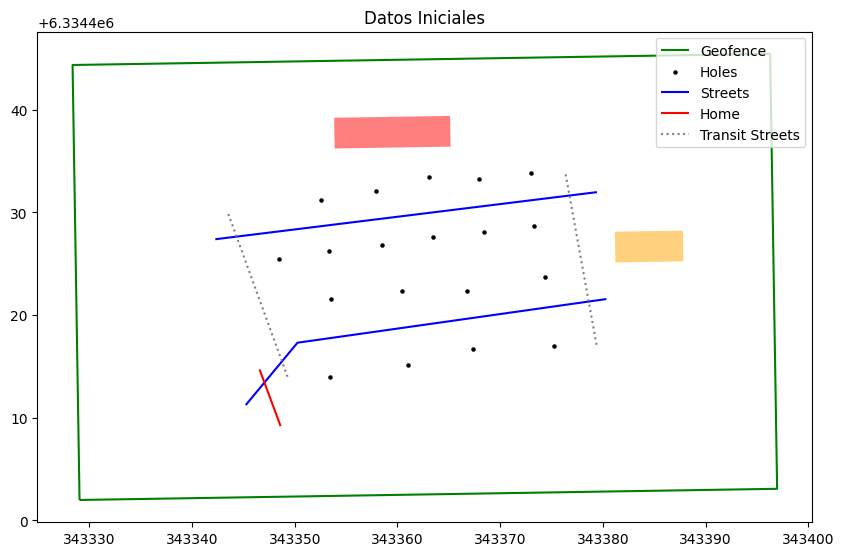

In [3]:
fig, ax = plt.subplots(figsize=(10, 10))
geofence.boundary.plot(ax=ax, color='green', label='Geofence')
holes.plot(ax=ax, color='black', markersize=5, label='Holes')
streets.plot(ax=ax, color='blue', label='Streets')
home_pose.plot(ax=ax, color='red', label='Home')
if transit_streets is not None:
    transit_streets.plot(ax=ax, color='gray', linestyle=':', label='Transit Streets')
if obstacles is not None:
    obstacles.plot(ax=ax, color='orange', alpha=0.5, label='Obstacles')
if high_obstacles is not None:
    high_obstacles.plot(ax=ax, color='red', alpha=0.5, label='High Obstacles')
plt.legend()
plt.title("Datos Iniciales")
plt.show()

## 3. Ajuste de Calles (Fit Streets)
El algoritmo ajusta las calles dibujadas para que pasen de manera óptima entre las filas de pozos.

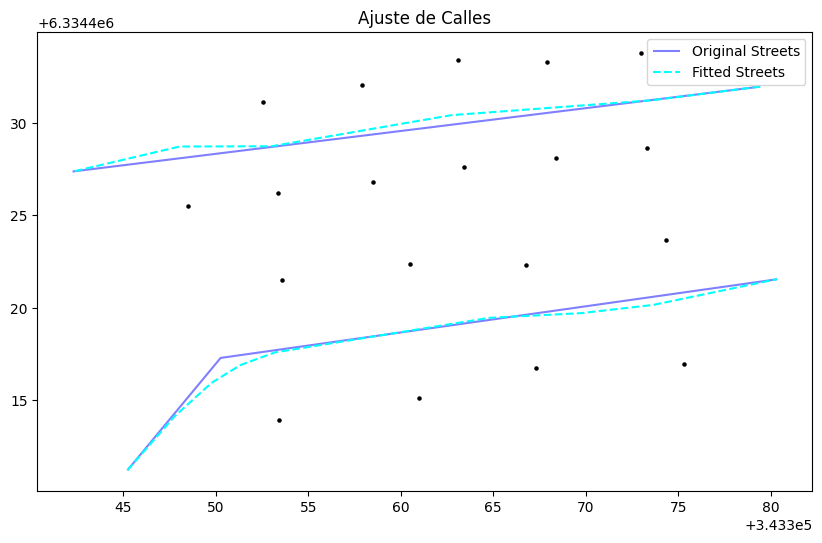

In [4]:
fit_streets_enabled = True
fit_twice = True

streets_fitted = streets.copy()
if fit_streets_enabled:
    # Pass streets_fitted (the copy) so 'streets' remains original
    streets_fitted = fit_all_streets(streets_fitted, holes, geofence, obstacles, None, fit_twice)

fig, ax = plt.subplots(figsize=(10, 10))
streets.plot(ax=ax, color='blue', alpha=0.5, label='Original Streets')
streets_fitted.plot(ax=ax, color='cyan', linestyle='--', label='Fitted Streets')
holes.plot(ax=ax, color='black', markersize=5)
plt.legend()
plt.title("Ajuste de Calles")
plt.show()

## 4. Filtrado y Definición de Zonas Bloqueadas
Se eliminan los pozos fuera del geofence o dentro de obstáculos, y se define el área 'blocked' (prohibida) para el robot.

In [5]:
OBSTACLE_BUFFER_DISTANCE = 0.75

# Definir zona bloqueada (Borde Geofence + Obstáculos)
blocked = gpd.GeoDataFrame(geometry=gpd.GeoSeries(geofence.boundary)).buffer(OBSTACLE_BUFFER_DISTANCE).unary_union
holes_filtered = holes[holes.within(geofence.unary_union)].reset_index(drop=True)

if obstacles is not None:
    blocked = blocked.union(obstacles.buffer(OBSTACLE_BUFFER_DISTANCE).unary_union)
    holes_filtered = holes_filtered[holes_filtered.within(geofence.unary_union - obstacles.unary_union)].reset_index(drop=True)

print(f"Pozos después del filtrado: {len(holes_filtered)}")

Pozos después del filtrado: 19


## 5. Asociación de Pozos a Calles
Para cada pozo, identificamos cuál es la calle más cercana desde donde se intentará el abordaje.

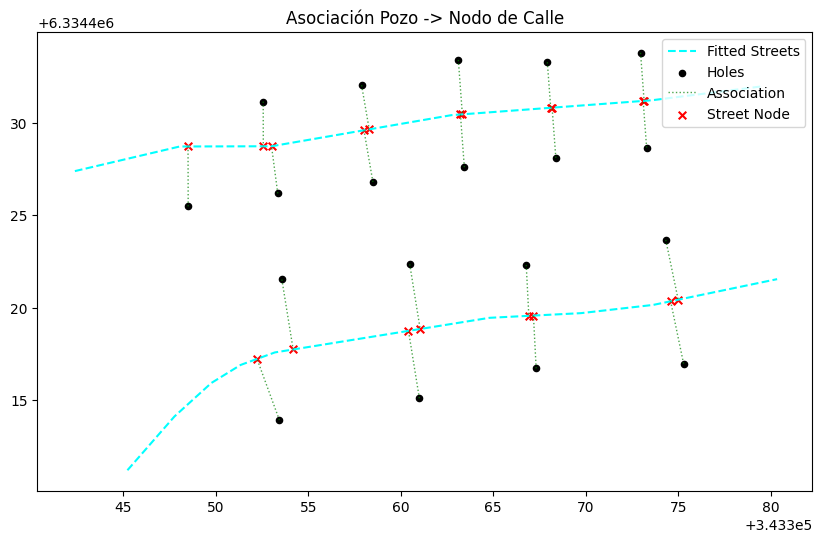

In [6]:
closest_streets = []
connection_lines = []
street_nodes_x = []
street_nodes_y = []

for i in range(0, len(holes_filtered)):
    distance = 10000.0
    closest_street = -1
    nearest_pt = None
    
    hole_point = holes_filtered['geometry'][i]
    
    for j in range(0, len(streets_fitted)):
        street = streets_fitted['geometry'][j]
        dist = hole_point.distance(street)
        if dist < distance:
            distance = dist
            closest_street = j
            # Find the actual nearest point on the line
            nearest_pt = nearest_points(hole_point, street)[1]
            
    closest_streets.append(closest_street)
    if nearest_pt:
        connection_lines.append(LineString([hole_point, nearest_pt]))
        street_nodes_x.append(nearest_pt.x)
        street_nodes_y.append(nearest_pt.y)
    
holes_filtered['closest_street'] = closest_streets

# Visualización de la Asociación
fig, ax = plt.subplots(figsize=(10, 10))
streets_fitted.plot(ax=ax, color='cyan', linestyle='--', label='Fitted Streets')
holes_filtered.plot(ax=ax, color='black', markersize=20, label='Holes')

# Plot connection lines
gpd.GeoSeries(connection_lines).plot(ax=ax, color='green', linestyle=':', linewidth=1, alpha=0.7, label='Association')

# Plot the projected nodes on the street
ax.scatter(street_nodes_x, street_nodes_y, color='red', marker='x', s=30, label='Street Node')

plt.title("Asociación Pozo -> Nodo de Calle")
plt.legend()
plt.show()

## 6. Generación de Poses de Calle Discretizado (Nodos del Grafo)
Discretizamos las líneas de las calles en puntos (poses) navegables.

Generadas 152 poses de calle con paso 0.5m.
Generadas 140 poses de tránsito con paso 0.5m.


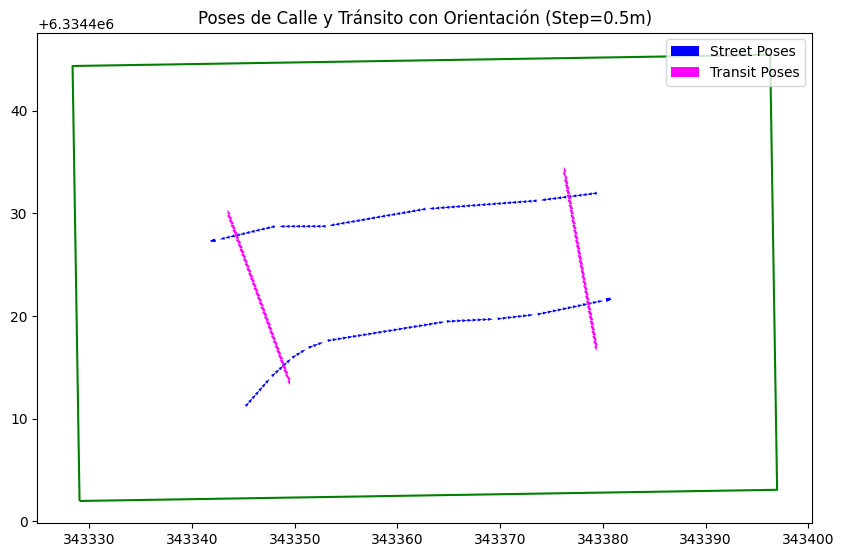

In [7]:
import numpy as np

# Configuración de Discretización
STREET_STEP_DISTANCE = 0.5 # metros. Ajustar para mayor/menor densidad de nodos.

# Generar Poses de Calle (Regular)
poses_street = utils.posesFromGeoDataFrame(
    streets_fitted, blocked, obstacles, None, geofence, 
    step_distance=STREET_STEP_DISTANCE
)
print(f"Generadas {len(poses_street)} poses de calle con paso {STREET_STEP_DISTANCE}m.")

# Generar Poses de Tránsito (Transit)
poses_transit = []
if transit_streets is not None:
    # Asegurar que tengan el tipo correcto para que utils lo procese
    transit_streets['type'] = 'transit_streets'
    poses_transit = utils.posesFromGeoDataFrame(
        transit_streets, blocked, obstacles, None, geofence, 
        step_distance=STREET_STEP_DISTANCE
    )
    print(f"Generadas {len(poses_transit)} poses de tránsito con paso {STREET_STEP_DISTANCE}m.")

# Visualizar
fig, ax = plt.subplots(figsize=(10, 10))
geofence.boundary.plot(ax=ax, color='green')

# Plot Regular Streets Poses
poses_arr = np.array(poses_street)
if len(poses_arr) > 0:
    X = poses_arr[:, 0]
    Y = poses_arr[:, 1]
    Theta = poses_arr[:, 2]
    U = np.cos(Theta)
    V = np.sin(Theta)
    ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=2, color='blue', width=0.002, label='Street Poses')

# Plot Transit Streets Lines and Poses
if transit_streets is not None:
    #transit_streets.plot(ax=ax, color='magenta', linestyle=':', label='Transit Streets') #Original
    
    if len(poses_transit) > 0:
        poses_arr_t = np.array(poses_transit)
        Xt = poses_arr_t[:, 0]
        Yt = poses_arr_t[:, 1]
        Thetat = poses_arr_t[:, 2]
        Ut = np.cos(Thetat)
        Vt = np.sin(Thetat)
        ax.quiver(Xt, Yt, Ut, Vt, angles='xy', scale_units='xy', scale=2, color='magenta', width=0.002, label='Transit Poses')

plt.title(f"Poses de Calle y Tránsito con Orientación (Step={STREET_STEP_DISTANCE}m)")
plt.legend()
plt.show()

## 7. Generación de Poses de Carguío (Loading Poses)
Esta es la etapa crítica: se calculan las trayectorias curvas desde la calle hasta cada pozo.

generating loading poses
Generadas poses de carguío para 19 pozos.


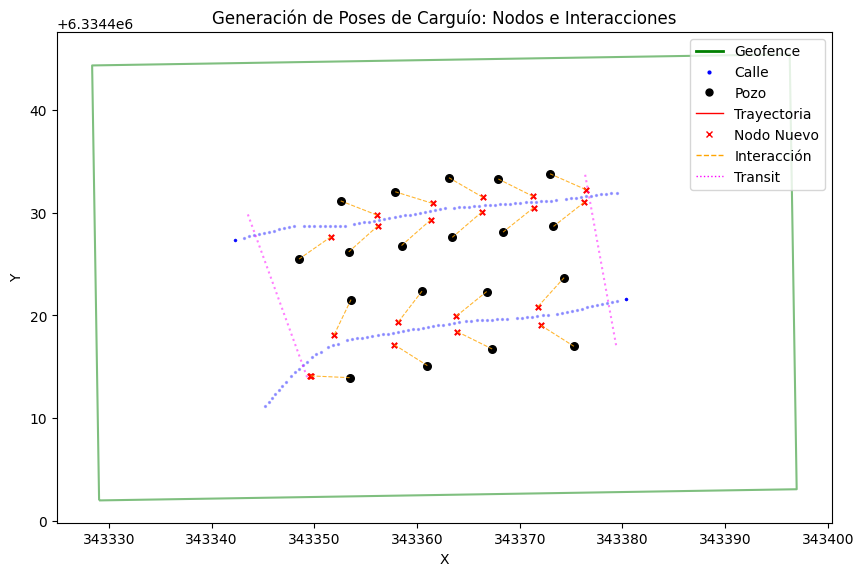

In [8]:
# Mock para el callback de progreso
class MockSignal:
    def emit(self, val):
        pass

TURNING_RADIUS = 3.0
HOLE_DISTANCE = 2.5 + 1.3

# Preparar home pose (simplificado)
# Asumimos que home_pose tiene una geometría válida
home_coords = list(home_pose.geometry[0].coords)
import math
home_angle = math.atan2(home_coords[1][1]-home_coords[0][1], home_coords[1][0]-home_coords[0][0])
home_pose_0 = [[home_coords[0][0], home_coords[0][1], home_angle]]

prev_poses = home_pose_0 + poses_street

# Generar Loading Poses
poses_holes, extra_connections = utils.generateLoadingPoses(
    streets_fitted, holes_filtered, blocked, prev_poses, 
    OBSTACLE_BUFFER_DISTANCE, TURNING_RADIUS, HOLE_DISTANCE, MockSignal()
)

print(f"Generadas poses de carguío para {len(poses_holes)} pozos.")

# --- Visualización de los Nodos Calculados con Pozos ---
fig, ax = plt.subplots(figsize=(10, 10))
geofence.boundary.plot(ax=ax, color='green', alpha=0.5, label='Geofence')
if transit_streets is not None:
    transit_streets.plot(ax=ax, color='magenta', linestyle=':', alpha=0.5, label='Transit Streets')

# Pozos (Holes)
if 'holes_filtered' in locals():
    holes_filtered.plot(ax=ax, color='black', marker='o', markersize=30, label='Pozos')
    # Annotate holes for clarity if needed, or just interactions
    
# Poses de Calle (Contexto)
poses_arr = np.array(poses_street)
if len(poses_arr) > 0:
    ax.scatter(poses_arr[:, 0], poses_arr[:, 1], c='blue', s=2, alpha=0.3, label='Calles')

# Nuevos Nodos y Trayectorias e Interacciones
all_x_hole = []
all_y_hole = []

# Assuming poses_holes aligns with holes_filtered indices as per generateLoadingPoses logic
for idx, hole_ps in enumerate(poses_holes):
    if hole_ps:
        arr = np.array(hole_ps)
        all_x_hole.extend(arr[:,0])
        all_y_hole.extend(arr[:,1])
        # Plot trayectorias
        ax.plot(arr[:,0], arr[:,1], c='red', linewidth=1, alpha=0.7)
        
        # Interaction: Line from last pose to hole center
        if 'holes_filtered' in locals() and idx < len(holes_filtered):
            hole_geom = holes_filtered.iloc[idx].geometry
            last_pose = arr[-1]
            # Draw dashed line to hole
            ax.plot([last_pose[0], hole_geom.x], [last_pose[1], hole_geom.y], 
                    c='orange', linestyle='--', linewidth=0.8, alpha=0.8)

# Resaltar Nodos Nuevos
ax.scatter(all_x_hole, all_y_hole, c='red', s=15, marker='x', label='Nuevos Nodos')

# Custom legend elements to handle geodataframe plots which might not auto-legend well
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color='green', lw=2, label='Geofence'),
    Line2D([0], [0], color='blue', marker='o', lw=0, markersize=2, label='Calle'),
    Line2D([0], [0], color='black', marker='o', lw=0, markersize=5, label='Pozo'),
    Line2D([0], [0], color='red', lw=1, label='Trayectoria'),
    Line2D([0], [0], color='red', marker='x', lw=0, markersize=5, label='Nodo Nuevo'),
    Line2D([0], [0], color='orange', linestyle='--', lw=1, label='Interacción')
]
if transit_streets is not None:
    custom_lines.append(Line2D([0], [0], color='magenta', linestyle=':', lw=1, label='Transit'))

ax.legend(handles=custom_lines, loc='upper right')
plt.title("Generación de Poses de Carguío: Nodos e Interacciones")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

## 8. Visualización Final de Rutas
Mostramos las trayectorias calculadas (en rojo) conectando las calles (azul) con los pozos.

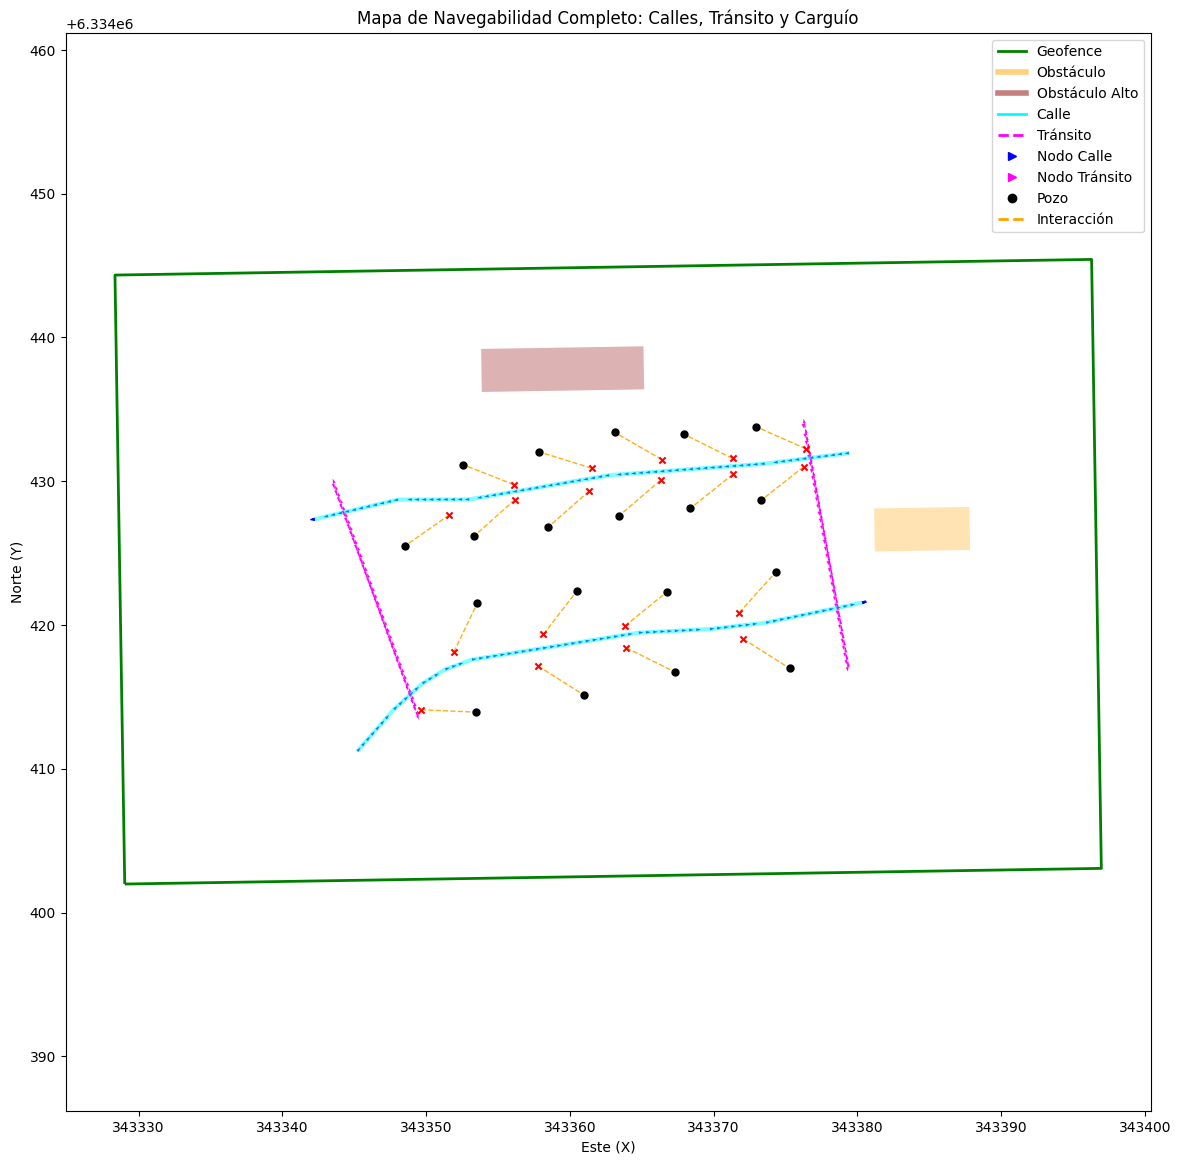

In [9]:

# --- Visualización Final e Integradora (Step 8) ---
# Muestra todos los elementos generados con orientación e interacciones
fig, ax = plt.subplots(figsize=(14, 14))

# 1. Contexto (Geofence y Obstaculos)
if 'geofence' in locals():
    geofence.boundary.plot(ax=ax, color='green', linewidth=2, label='Geofence')
if 'obstacles' in locals() and not obstacles.empty:
    obstacles.plot(ax=ax, color='orange', alpha=0.3, label='Obstáculos')
if 'high_obstacles' in locals() and not high_obstacles.empty:
    high_obstacles.plot(ax=ax, color='darkred', alpha=0.3, label='Obst. Altos')

# 2. Vías de Acceso (Calles y Tránsito)
if 'streets_fitted' in locals():
    streets_fitted.plot(ax=ax, color='cyan', alpha=0.5, linestyle='-', linewidth=3, label='Calles Ajustadas')
if 'transit_streets' in locals() and transit_streets is not None:
    transit_streets.plot(ax=ax, color='magenta', linestyle='--', linewidth=1, label='Rutas Tránsito')

# 3. Nodos de Navegación con Orientación (Flechas)
# Nodos Calle
if 'poses_street' in locals() and len(poses_street) > 0:
    ps_arr = np.array(poses_street)
    # Quiver plot for orientation
    X = ps_arr[:, 0]
    Y = ps_arr[:, 1]
    Theta = ps_arr[:, 2]
    U = np.cos(Theta)
    V = np.sin(Theta)
    ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=3, color='blue', width=0.003, label='Nodos Calle')

# Nodos Tránsito
if 'poses_transit' in locals() and len(poses_transit) > 0:
    pt_arr = np.array(poses_transit)
    Xt = pt_arr[:, 0]
    Yt = pt_arr[:, 1]
    Thetat = pt_arr[:, 2]
    Ut = np.cos(Thetat)
    Vt = np.sin(Thetat)
    ax.quiver(Xt, Yt, Ut, Vt, angles='xy', scale_units='xy', scale=3, color='magenta', width=0.003, label='Nodos Tránsito')

# 4. Detalles de Carguío (Pozos, Trayectorias e Interacciones)
if 'holes_filtered' in locals():
    holes_filtered.plot(ax=ax, color='black', marker='o', markersize=25, zorder=4, label='Pozos')

if 'poses_holes' in locals():
    for idx, hp in enumerate(poses_holes):
        if hp:
            hp_arr = np.array(hp)
            # Trayectoria
            # ax.plot(hp_arr[:,0], hp_arr[:,1], c='red', linewidth=1.5, alpha=0.8)
            # Nodo final
            ax.scatter(hp_arr[-1,0], hp_arr[-1,1], c='red', s=20, marker='x', zorder=5)
            
            # Interacción (Línea naranja al centro del pozo)
            if 'holes_filtered' in locals() and idx < len(holes_filtered):
                hole_geom = holes_filtered.iloc[idx].geometry
                last_pose = hp_arr[-1]
                ax.plot([last_pose[0], hole_geom.x], [last_pose[1], hole_geom.y], 
                        c='orange', linestyle='--', linewidth=1.0, alpha=0.9)

# 5. Configuración del Gráfico
plt.title("Mapa de Navegabilidad Completo: Calles, Tránsito y Carguío")
plt.xlabel("Este (X)")
plt.ylabel("Norte (Y)")
plt.axis('equal')

# Legend handling
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color='green', lw=2, label='Geofence'),
    Line2D([0], [0], color='orange', alpha=0.5, lw=4, label='Obstáculo'),
    Line2D([0], [0], color='darkred', alpha=0.5, lw=4, label='Obstáculo Alto'),
    Line2D([0], [0], color='cyan', lw=2, label='Calle'),
    Line2D([0], [0], color='magenta', linestyle='--', lw=2, label='Tránsito'),
    Line2D([0], [0], color='blue', marker='>', lw=0, markersize=6, label='Nodo Calle'),
    Line2D([0], [0], color='magenta', marker='>', lw=0, markersize=6, label='Nodo Tránsito'),
    Line2D([0], [0], color='black', marker='o', lw=0, markersize=6, label='Pozo'),
    # Line2D([0], [0], color='red', lw=2, label='Trayectoria Carguío'),
    Line2D([0], [0], color='orange', linestyle='--', lw=2, label='Interacción')
]
ax.legend(handles=custom_lines, loc='upper right')
plt.show()